In [1]:
import keras
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import tensorflow as tf
from PIL import Image
from sklearn.metrics import accuracy_score
import re


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.preprocessing import image

In [5]:
df=pd.read_csv('df_f.csv')
df

,Image,Category
0,battery/battery1.jpg,0
1,battery/battery10.jpg,0
2,battery/battery100.jpg,0
3,battery/battery101.jpg,0
4,battery/battery102.jpg,0
...,...,...
15510,white-glass/white-glass95.jpg,12
15511,white-glass/white-glass96.jpg,12
15512,white-glass/white-glass97.jpg,12
15513,white-glass/white-glass98.jpg,12


In [6]:
garbage_types_labels = {
    0: 'battery',
    1: 'biological',
    3: 'brown-glass',
    4: 'cardboard',
    5: 'clothes',
    6: 'green-glass',
    7: 'metal',
    8: 'paper',
    9: 'plastic',
    10: 'shoes',
    11: 'trash',
    12: 'white-glass'
}

In [7]:
df

,Image,Category
0,battery/battery1.jpg,0
1,battery/battery10.jpg,0
2,battery/battery100.jpg,0
3,battery/battery101.jpg,0
4,battery/battery102.jpg,0
...,...,...
15510,white-glass/white-glass95.jpg,12
15511,white-glass/white-glass96.jpg,12
15512,white-glass/white-glass97.jpg,12
15513,white-glass/white-glass98.jpg,12


In [8]:
df["Category"] = df["Category"].replace(garbage_types_labels) 

In [9]:
df

,Image,Category
0,battery/battery1.jpg,battery
1,battery/battery10.jpg,battery
2,battery/battery100.jpg,battery
3,battery/battery101.jpg,battery
4,battery/battery102.jpg,battery
...,...,...
15510,white-glass/white-glass95.jpg,white-glass
15511,white-glass/white-glass96.jpg,white-glass
15512,white-glass/white-glass97.jpg,white-glass
15513,white-glass/white-glass98.jpg,white-glass


In [10]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train = train_df.shape[0]
validate = validate_df.shape[0]
test=test_df.shape[0]

In [11]:
test

1552

In [12]:
validate

1551

In [13]:
train

12412

In [15]:
train_df['Category'].value_counts()

Category
clothes        4238
shoes          1596
paper           844
biological      804
battery         751
cardboard       717
plastic         685
white-glass     630
metal           601
trash           571
green-glass     498
brown-glass     477
Name: count, dtype: int64

In [16]:
validate_df['Category'].value_counts()

Category
clothes        548
shoes          200
biological     105
plastic         92
metal           89
battery         87
paper           86
white-glass     77
cardboard       76
brown-glass     67
green-glass     63
trash           61
Name: count, dtype: int64

In [17]:
test_df['Category'].value_counts()

Category
clothes        539
shoes          181
paper          120
battery        107
cardboard       98
plastic         88
metal           79
biological      76
white-glass     68
green-glass     68
trash           65
brown-glass     63
Name: count, dtype: int64

### TO CSV

In [18]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv',index=False)
validate_df.to_csv('validation.csv',index=False)

In [19]:
num_classes=12

In [20]:
img_height = 224
img_width = 224
img_size=(img_width,img_height)

In [21]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
data_directory = "garbage_classification/"

In [23]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    directory=data_directory, 
    x_col='Image',
    y_col='Category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=32
)

Found 12412 validated image filenames belonging to 12 classes.


In [24]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory=data_directory,
    x_col='Image',
    y_col='Category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=32)

Found 1551 validated image filenames belonging to 12 classes.


In [25]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=data_directory,
    x_col='Image',
    y_col='Category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=32
)

Found 1552 validated image filenames belonging to 12 classes.


# 1. model_0306_efficientnetB0

In [75]:
from datetime import datetime
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

#model_0306_efficientnetB0

def create_model(path, name, img_height, img_width, train_generator, validation_generator, epochs):
    num_classes = 12

    start = datetime.now()

    # Crear el modelo base
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Definir el modelo final
    model = Model(inputs=base_model.input, outputs=predictions)

    # Congelar las capas del modelo base
    for layer in base_model.layers:
        layer.trainable = False

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history=model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    try:
        model.save(f"{path}/{name}.h5")
    except:
        print("Modelo no guardado")

    end = datetime.now()

    print(f"It took {end-start} time")
    
    return history


In [ ]:
history=create_model(".", "model_0306_efficientnetB0", 224, 224, train_generator, validation_generator, epochs=1)

 45/388 [==>...........................] - ETA: 7:42 - loss: 0.6474 - accuracy: 0.8090

NameError: name 'history' is not defined

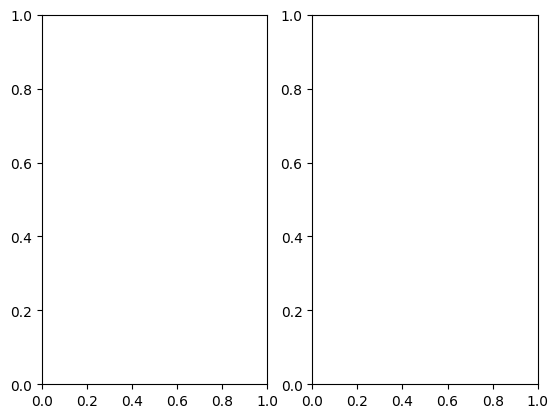

In [77]:
import matplotlib.pyplot as plt

epochs = list(range(1, 10 + 1))
fig, ax = plt.subplots(1, 2)
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', color='r', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'go-', label='Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', color='r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'go-', label='Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()


# 1.1 Retrain model_0306_efficientnetB0

In [58]:
from tensorflow.keras.models import load_model
from datetime import datetime

def retrain_model(model_path, img_height, img_width, train_generator, validation_generator, epochs, save_path, save_name):
    start = datetime.now()

    # Cargar el modelo desde el archivo guardado
    model = load_model(model_path)

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history=model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    # Guardar el modelo una vez finalizado el entrenamiento
    try:
        model.save(f"{save_path}/{save_name}.h5")
        print("Modelo guardado correctamente.")
    except:
        print("Error al guardar el modelo.")

    end = datetime.now()
    print(f"Tiempo de entrenamiento: {end-start}")


In [59]:
retrain_model("model_0306_efficientnetB0.h5", 224, 224, train_generator, validation_generator, epochs=10, save_path=".", save_name="model_0306_efficientnetB0_retrain1")

Epoch 1/10
388/388 [==============================] - 590s 2s/step - loss: 0.0886 - accuracy: 0.9704 - val_loss: 0.1557 - val_accuracy: 0.9516
Epoch 2/10
388/388 [==============================] - 619s 2s/step - loss: 0.0447 - accuracy: 0.9850 - val_loss: 0.1527 - val_accuracy: 0.9613
Epoch 3/10
388/388 [==============================] - 580s 1s/step - loss: 0.0241 - accuracy: 0.9927 - val_loss: 0.1525 - val_accuracy: 0.9632
Epoch 4/10
388/388 [==============================] - 577s 1s/step - loss: 0.0155 - accuracy: 0.9952 - val_loss: 0.1848 - val_accuracy: 0.9542
Epoch 5/10
388/388 [==============================] - 606s 2s/step - loss: 0.0196 - accuracy: 0.9930 - val_loss: 0.1913 - val_accuracy: 0.9587
Epoch 6/10
388/388 [==============================] - 603s 2s/step - loss: 0.0193 - accuracy: 0.9929 - val_loss: 0.1916 - val_accuracy: 0.9613
Epoch 7/10
388/388 [==============================] - 588s 2s/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.1826 - val_accuracy: 0.9562

In [ ]:
epochs = list(range(len(history.history['accuracy'])))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'go-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

# 2. model_0306_efficientnetB0 V2 + FINE+TUNNING

In [48]:
from datetime import datetime
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#model_0306_efficientnetB0.v2

def create_model(path, name, img_height, img_width, train_generator, validation_generator, epochs, fine_tuning=False, data_augmentation=False):
    num_classes = 12

    start = datetime.now()

    # Crear el modelo base
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Definir el modelo final
    model = Model(inputs=base_model.input, outputs=predictions)

    # Congelar las capas del modelo base
    for layer in base_model.layers:
        layer.trainable = False

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    if data_augmentation:
        # Aplicar data augmentation durante el entrenamiento
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=data_directory,
            x_col='Image',
            y_col='Category',
            target_size=(img_height, img_width),
            class_mode='categorical',
            batch_size=32
        )

    if fine_tuning:
        # Descongelar las últimas capas del modelo base para el ajuste fino
        for layer in base_model.layers[-20:]:
            layer.trainable = True

    history=model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    try:
        model.save(f"{path}/{name}.h5")
    except:
        print("Modelo no guardado")

    end = datetime.now()

    print(f"It took {end-start} time")


In [50]:
create_model(".", "model_0306_efficientnetB0v2.h5", 224, 224, train_generator, validation_generator, epochs=2)

Epoch 1/2
388/388 [==============================] - 577s 1s/step - loss: 0.2259 - accuracy: 0.9307 - val_loss: 0.1610 - val_accuracy: 0.9484
Epoch 2/2
388/388 [==============================] - 596s 2s/step - loss: 0.0716 - accuracy: 0.9766 - val_loss: 0.1711 - val_accuracy: 0.9562
It took 0:19:34.726723 time


# RESNET50

In [ ]:
from datetime import datetime
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def create_model(path, name, img_height, img_width, train_generator, validation_generator, epochs):
    num_classes = 12

    start = datetime.now()

    # Crear el modelo base
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Definir el modelo final
    model = Model(inputs=base_model.input, outputs=predictions)

    # Congelar las capas del modelo base
    for layer in base_model.layers:
        layer.trainable = False

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    try:
        model.save(f"{path}/{name}.h5")
    except:
        print("Modelo no guardado")

    end = datetime.now()
    print(f"It took {end-start} time")

    return history


# PREDICTIONS

1. Prediction model_0306_efficientnetB0 INITIAL VERSION
2. Prediction model_0306_efficientnetB0 TRENAINED
3. Prediction model_0306_efficientnetB0 v2 + fine tunning

# 1. Prediction model_0306_efficientnetB0

In [41]:
from tensorflow.keras.models import load_model
model = load_model("model_0306_efficientnetB0.h5")

Cardboard prediction

In [43]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\cardboard1.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 1s 799ms/step
Confianza (%): 22.29856848716736
La imagen es: 8
La imagen es: plastic
[[0.0977457  0.01822413 0.06794209 0.13780573 0.02394277 0.07599938
  0.05021247 0.0256495  0.22298568 0.04322841 0.04679032 0.18947382]]


Clothes prediction

In [44]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\clothes4.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 0s 63ms/step
Confianza (%): 22.076191008090973
La imagen es: 8
La imagen es: plastic
[[0.0985826  0.01801476 0.06834672 0.13927701 0.02328959 0.07531924
  0.05061185 0.02567274 0.22076191 0.04325297 0.04735589 0.18951473]]


In [ ]:
Plastic prediction

In [46]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\plastic3.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 0s 51ms/step
Confianza (%): 22.18020111322403
La imagen es: 8
La imagen es: plastic
[[0.09863587 0.01780101 0.06843559 0.13816716 0.02324804 0.07571573
  0.05064634 0.0255187  0.22180201 0.04312144 0.04701281 0.18989532]]


# 2. Prediction model_0306_efficientnetB0 RE-TRAINED

In [61]:
from tensorflow.keras.models import load_model
model_re = load_model("model_0306_efficientnetB0_retrain1.h5")

Cardboard prediction

In [63]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\cardboard1.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model_re.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 0s 54ms/step
Confianza (%): 61.84994578361511
La imagen es: 8
La imagen es: plastic
[[3.55317220e-02 7.90315680e-05 2.86725000e-04 1.13074845e-02
  1.43049892e-05 1.12471702e-02 2.95381087e-05 2.57319207e-05
  6.18499458e-01 1.97430491e-05 3.01908404e-01 2.10507307e-02]]


Clothes prediction

In [66]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\clothes4.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model_re.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 0s 53ms/step
Confianza (%): 60.5488657951355
La imagen es: 8
La imagen es: plastic
[[3.7629820e-02 7.8805992e-05 3.0195367e-04 1.2075156e-02 1.3901715e-05
  1.1129593e-02 3.1575331e-05 2.6693622e-05 6.0548866e-01 2.0411780e-05
  3.1134942e-01 2.1853948e-02]]


In [ ]:
Plastic prediction

In [65]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\plastic3.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model_re.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 0s 49ms/step
Confianza (%): 61.24998927116394
La imagen es: 8
La imagen es: plastic
[[3.7547827e-02 7.5313983e-05 2.9978697e-04 1.1752524e-02 1.3750690e-05
  1.1082111e-02 3.1653788e-05 2.6112548e-05 6.1249989e-01 2.0201704e-05
  3.0476332e-01 2.1887485e-02]]


# 3. Prediction model_0306_efficientnetB0 v2 + fine tunning

In [54]:
from tensorflow.keras.models import load_model
model = load_model("model_0306_efficientnetB0v2.h5.h5")

Cardboard prediction

In [55]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\cardboard1.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 1s 789ms/step
Confianza (%): 23.227618634700775
La imagen es: 10
La imagen es: trash
[[0.03479067 0.01096367 0.02473339 0.13694571 0.00771833 0.15003772
  0.01777375 0.01272381 0.17304362 0.01811986 0.23227619 0.18087327]]


Clothes prediction

In [56]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\clothes4.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 0s 47ms/step
Confianza (%): 23.16683679819107
La imagen es: 10
La imagen es: trash
[[0.03537419 0.01083573 0.02458145 0.1377377  0.0075525  0.14871559
  0.01766006 0.01275216 0.17369632 0.01840163 0.23166837 0.18102431]]


Plastisc prediction

In [57]:
import numpy as np
from PIL import Image

# Ruta de la imagen en tu ordenador
image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\photo_test\plastic3.jpg"

# Cargar la imagen en color
image = Image.open(image_path).convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por el modelo
img_width, img_height = 224, 224  # Usar las dimensiones adecuadas para tu modelo
image = image.resize((img_width, img_height))

# Convertir la imagen en un arreglo numpy
image_array = np.array(image)

# Añadir una dimensión adicional para el batch
image_array = np.expand_dims(image_array, axis=0)

# Preprocesar la imagen (normalización, etc.) de acuerdo con el modelo
image_array = image_array.astype('float32')
image_array /= 255

predictions = model.predict(image_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print("Confianza (%):", confidence)

print("La imagen es:", predicted_class)
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

predicted_label = class_labels[predicted_class]
print('La imagen es:', predicted_label)
print(predictions)

1/1 [==============================] - 0s 54ms/step
Confianza (%): 23.057889938354492
La imagen es: 10
La imagen es: trash
[[0.03521813 0.0106923  0.02449142 0.13761519 0.00754191 0.14961974
  0.01771424 0.01274806 0.17468114 0.01835035 0.2305789  0.18074863]]
